# Bibliotecas que e funções que serão utilizadas

In [1]:
import os.path
import os
import gc
import pathlib
import glob
import PIL
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL as p
import random
#=====================================================================================================================#
from PIL import Image
#=====================================================================================================================#
%matplotlib inline
#=====================================================================================================================#
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
#=====================================================================================================================#
from sklearn.model_selection import StratifiedKFold , KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Separando as imagens do banco em duas categorias

In [2]:
def rotaciona(image,img_size):
    
    angulos=[90,180,-90]     #Ângulos comuns de rotação que podem aparecer
    random.shuffle(angulos)  #Torna aleatório a escolha do 1º ângulo. Este passo será importante para os códigos seguintes
             
    im2 = Image.open(image).convert('L')
    im2 = im2.resize((img_size,img_size))
    
    #Rotacionando a imagem com um dos ângulos dados. A escolha é do ângulo é aleatória
    im2=im2.rotate(angulos[0], PIL.Image.NEAREST, expand = 1)        
    
    return im2

In [3]:
img_path = 'C:\\Users\\Alyfe Renan Gomes\\Programação\\Código da IC'

imagens_banco = list(filter(lambda x: True if x.endswith('png') else False,os.listdir(img_path)))

random.shuffle(imagens_banco)

Rotaciona = imagens_banco[:int((len(imagens_banco)+1)*.5)]
Nao_Rotaciona = imagens_banco[int((len(imagens_banco)+1)*.5):]

In [ ]:
img_size = 180

#Guardando as imagens rotacionadas
for index, image in enumerate(Rotaciona):
    identificador=image[7:13]
    rotaciona_path= f'C:\\Users\\Alyfe Renan Gomes\\Programação\\Código da IC\\Teste de Rotação\\Com rotacao\\{identificador}'
    image = rotaciona(image,img_size)
    
    image.save(rotaciona_path+".png")

#Guardando as imagens não rotacionadas    
for index, image in enumerate(Nao_Rotaciona):
    identificador=image[0:13]
    nao_rotaciona_path= f'C:\\Users\\Alyfe Renan Gomes\\Programação\\Código da IC\\Teste de Rotação\\Sem rotacao\\{identificador}'
    
    im2 = Image.open(image).convert('L')
    im2 = im2.resize((img_size,img_size))
    
    im2.save(nao_rotaciona_path+".png")

# =============================================================

# Pegando os dados

In [4]:
data_dir2 = 'C:\\Users\\Alyfe Renan Gomes\\Programação\\Código da IC\\Teste de Rotação'
data_dir2 = pathlib.Path(data_dir2)

In [5]:
#Definindo função útil
def get_images(Rot_path,SemRot_path):
    "Função que retorna duas listas: uma com as imagens rotacionadas e a outra com imagens sem rotação"
    
    Rot_images= list(filter(lambda x: True if x.endswith('png') else False,os.listdir(Rot_path)))
    NRot_images = list(filter(lambda x: True if x.endswith('png') else False,os.listdir(SemRot_path)))
    
    return Rot_images, NRot_images

#=====================================================================================================================#

#Caso desejado utilizar a função, modifique para o path no qual as imagens estão.
Rot_path=r'C:\\Users\\Alyfe Renan Gomes\\Programação\\Código da IC\\Teste de Rotação\\Com rotacao'
SemRot_path=r'C:\\Users\\Alyfe Renan Gomes\\Programação\\Código da IC\\Teste de Rotação\\Sem rotacao'

Rot1, Sem_Rot1 = get_images(Rot_path,SemRot_path)


print(len(Sem_Rot1), len(Rot1))

323 324


In [6]:
Sem_Rot = list(data_dir2.glob('Sem rotacao/*'))
print(Sem_Rot[0])

Rot = list(data_dir2.glob('Com rotacao/*'))
print(Rot[0])

#PIL.Image.open(str(cxr[0]))

C:\Users\Alyfe Renan Gomes\Programação\Código da IC\Teste de Rotação\Sem rotacao\CHNCXR_0001_0.png
C:\Users\Alyfe Renan Gomes\Programação\Código da IC\Teste de Rotação\Com rotacao\0002_0.png


# =============================================================

# Definindo dados de teste e validação

In [7]:
#Separando os dados para teste
IMG_SIZE=180
batch_size=25
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir2,
  label_mode='categorical', 
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 647 files belonging to 2 classes.
Using 583 files for training.


In [8]:
#Separando os dados para validação
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir2,
  validation_split=0.1,
  label_mode='categorical', 
  subset="validation",
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=batch_size)

Found 647 files belonging to 2 classes.
Using 64 files for validation.


In [9]:
#Identificando as classes
class_names=train_ds.class_names
print(class_names)

['Com rotacao', 'Sem rotacao']


# =============================================================

# Treinando o modelo

In [14]:
#Função útil
def get_model(IMG_SIZE):
    
    model = Sequential()
    
    base_model =applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base_model.layers:
        layer.trainable=False
    
    model.add(base_model)
    model.add(Flatten())
    
    model.add(Dense(10, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                  metrics=['accuracy'])
    return model

In [15]:
resnet_model = get_model(IMG_SIZE)

resnet_model.summary()  #Visualizando o que foi criado

#=====================================================================================================================#

#Realizando o treinamento
epochs=10
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 10)                737290    
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 24,325,024
Trainable params: 737,312
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10
24/24 [==================

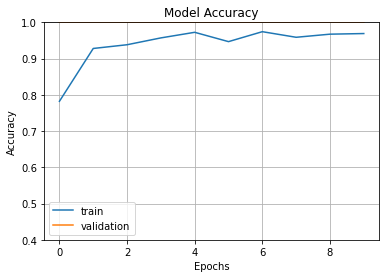

In [16]:
#Avaliando o modelo
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# =============================================================

# Fazendo previsões

In [18]:
import cv2
image=cv2.imread('CHNCXR_0501_1.png')
#[CHNCXR_0083_0,CHNCXR_0145_0,CHNCXR_0131_0 -> CHNCXR_0122_0] / [CHNCXR_0625_1,CHNCXR_0609_1,CHNCXR_0568_1 -> CHNCXR_0644_1]
image_resized= cv2.resize(image, (IMG_SIZE,IMG_SIZE))
image=np.expand_dims(image_resized,axis=0)

In [19]:
pred=resnet_model.predict(image)
print(pred)

[[5.002379e-07 9.999995e-01]]


In [20]:
output_class=class_names[np.argmax(pred)]
print("Predição: ", output_class)

Predição:  Sem rotacao


# =============================================================

# Aplicando Cross-Validation

### Gerando um dataframe com as imagens

In [24]:
#Definindo meu path
images_path=r'C:\\Users\\Alyfe Renan Gomes\\Programação\\Código da IC\\Teste de Rotação\\Sem rotacao'
Sem_Rot1 = list(filter(lambda x: True if x.endswith('png') else False,os.listdir(images_path)))

images_path2=r'C:\\Users\\Alyfe Renan Gomes\\Programação\\Código da IC\\Teste de Rotação\\Com rotacao'
Rot1 = list(filter(lambda x: True if x.endswith('png') else False,os.listdir(images_path2)))

print(len(Sem_Rot1),len(Rot1))

323 324


In [25]:
#Construindo as linhas e colunas do meu dataframe
auxiliar1=Sem_Rot1
for image in Rot1:
    auxiliar1.append(image)

auxiliar2=["Sem rotacao"]*323

for i in ["Com rotacao"]*324:
    auxiliar2.append(i)

In [26]:
len(Nao_Rotaciona)

323

In [27]:
print(len(auxiliar1),len(auxiliar2))

647 647


In [28]:
#Criando o dataframe com as imagens relacionando elas com as suas respectivas classes
df=pd.DataFrame()
df['Image']=list(auxiliar1)
df['Class']=list(auxiliar2)
df

,Image,Class
0,CHNCXR_0001_0.png,Sem rotacao
1,CHNCXR_0004_0.png,Sem rotacao
2,CHNCXR_0005_0.png,Sem rotacao
3,CHNCXR_0008_0.png,Sem rotacao
4,CHNCXR_0009_0.png,Sem rotacao
...,...,...
642,0653_1.png,Com rotacao
643,0655_1.png,Com rotacao
644,0657_1.png,Com rotacao
645,0660_1.png,Com rotacao


In [29]:
df.to_csv('train.csv', index = False)
train=pd.read_csv('train.csv')

In [73]:
# Iremos dividir o dataset
df = train.copy()

### Pegando os dados

In [30]:
TRAIN_PATH = 'C:\\Users\\Alyfe Renan Gomes\\Programação\\Código da IC\\Teste de Rotação\\Train'

### Preparando os Kfolds

In [31]:
# Guardando a média de todas as predições

main_pred = []
error = []
data_kfold = pd.DataFrame()

In [32]:
# Criando X,Y para treino

train_y = df.Class
train_x = df.drop(['Class'],axis=1)

In [35]:
IMG_SIZE = 180
BATCH_SIZE = 25
EPOCHS = 10
N_SPLIT = 10

### Treino e predição

In [47]:
#Iniciando Data Generators
train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
validation_datagen = ImageDataGenerator()

#=====================================================================================================================#

# k-fold
kfold = StratifiedKFold(n_splits=N_SPLIT,shuffle=True,random_state=42)

# Variable for keeping count of split we are executing
j = 0

# K-fold Train and test for each split
for train_idx, val_idx in list(kfold.split(train_x,train_y)):
    x_train_df = df.iloc[train_idx]
    x_valid_df = df.iloc[val_idx]
    j+=1
    
    training_set = train_datagen.flow_from_dataframe(dataframe=x_train_df, directory=TRAIN_PATH,
                                                 x_col="Image", y_col="Class",
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)
    
    validation_set = validation_datagen.flow_from_dataframe(dataframe=x_valid_df, directory=TRAIN_PATH,
                                                 x_col="Image", y_col="Class",
                                                 class_mode="categorical",
                                                 target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)
    
    model_test = get_model(IMG_SIZE)
    
    
    history = model_test.fit( training_set,
                                        validation_data=validation_set,
                                        epochs = EPOCHS,
                                        steps_per_epoch=x_train_df.shape[0] // BATCH_SIZE
                                        )
    
    test_generator = ImageDataGenerator()
    
    test_set = test_generator.flow_from_dataframe(dataframe=train, directory=TRAIN_PATH,
                                                 x_col="Image",y_col=None,
                                                 class_mode=None,
                                                 target_size=(IMG_SIZE,IMG_SIZE))
    
    #=====================================================================================================================#
    
    pred= model_test.predict(test_set, len(train) // BATCH_SIZE)
    predicted_class_indices=np.argmax(pred,axis=1)
                                       
    data_kfold[j] = predicted_class_indices
    gc.collect()

Found 582 validated image filenames belonging to 2 classes.
Found 65 validated image filenames belonging to 2 classes.
Epoch 1/10
23/23 [==============================] - 36s 1s/step - loss: 0.5720 - accuracy: 0.8312 - val_loss: 3.4277e-04 - val_accuracy: 1.0000
Epoch 2/10
23/23 [==============================] - 32s 1s/step - loss: 0.1422 - accuracy: 0.9210 - val_loss: 1.4598e-04 - val_accuracy: 1.0000
Epoch 3/10
23/23 [==============================] - 32s 1s/step - loss: 0.1372 - accuracy: 0.9497 - val_loss: 1.3757e-04 - val_accuracy: 1.0000
Epoch 4/10
23/23 [==============================] - 32s 1s/step - loss: 0.1165 - accuracy: 0.9336 - val_loss: 1.0421e-04 - val_accuracy: 1.0000
Epoch 5/10
23/23 [==============================] - 32s 1s/step - loss: 0.0999 - accuracy: 0.9497 - val_loss: 9.2065e-05 - val_accuracy: 1.0000
Epoch 6/10
23/23 [==============================] - 32s 1s/step - loss: 0.1249 - accuracy: 0.9515 - val_loss: 7.8078e-05 - val_accuracy: 1.0000
Epoch 7/10
23/23 

23/23 [==============================] - 32s 1s/step - loss: 0.1815 - accuracy: 0.9354 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 3/10
23/23 [==============================] - 32s 1s/step - loss: 0.0824 - accuracy: 0.9731 - val_loss: 5.6628e-04 - val_accuracy: 1.0000
Epoch 4/10
23/23 [==============================] - 32s 1s/step - loss: 0.0958 - accuracy: 0.9731 - val_loss: 4.1585e-04 - val_accuracy: 1.0000
Epoch 5/10
23/23 [==============================] - 32s 1s/step - loss: 0.0681 - accuracy: 0.9767 - val_loss: 3.3743e-04 - val_accuracy: 1.0000
Epoch 6/10
23/23 [==============================] - 32s 1s/step - loss: 0.0694 - accuracy: 0.9803 - val_loss: 2.8695e-04 - val_accuracy: 1.0000
Epoch 7/10
23/23 [==============================] - 32s 1s/step - loss: 0.0821 - accuracy: 0.9713 - val_loss: 1.7557e-04 - val_accuracy: 1.0000
Epoch 8/10
23/23 [==============================] - 32s 1s/step - loss: 0.0634 - accuracy: 0.9767 - val_loss: 1.1526e-04 - val_accuracy: 1.0000
Epoch 9

# =============================================================

In [48]:
# holder
data_kfold

,1,2,3,4,5,6,7,8,9,10
0,0,1,1,1,0,0,0,0,1,1
1,1,1,1,1,0,1,0,0,1,1
2,0,1,1,0,1,1,0,1,1,0
3,0,1,0,0,1,0,0,1,0,1
4,1,1,1,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
642,0,1,0,1,0,1,1,0,0,0
643,1,1,0,1,1,0,1,0,0,1
644,1,0,0,1,0,0,0,1,1,1
645,1,1,0,1,1,1,1,0,0,0


In [49]:
# testing on single iteration of HoldOut
predicted_class_indices = data_kfold[1]
labels=(training_set.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]

In [50]:
ans = train.copy()

In [51]:
# Taking The Label with Maximum Occurences

labels=(training_set.class_indices)
labels2=dict((v,k) for k,v in labels.items())
import collections 
for i in range(len(data_kfold)):
    co = collections.Counter(data_kfold.loc[i])
    co = sorted(co.items(),key=lambda x: x[1],reverse=True)
    ans.Class.loc[i] = labels2[co[0][0]]

In [52]:
# Averaged K-Fold Output
print("Accuracy of K-Fold Method: ", round(accuracy_score(train.Class,ans.Class),2))

Accuracy of K-Fold Method:  0.5
